In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [2]:

class RegressionDataset:
    def __init__(self, N=5000, batch_size=32, test_ratio=0.1, seed=None):
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Draw 5000 (x, y) pairs uniformly from [-10, 10] × [-10, 10]
        self.points = np.random.uniform(-10, 10, (N, 2)).astype(np.float32)
        # Compute label: f(x, y) = x^2 + x*y + y^2 for each (x, y) pair
        self.labels = (self.points[:, 0]**2 + self.points[:, 0]*self.points[:, 1] + self.points[:, 1]**2)\
                          .reshape(-1, 1).astype(np.float32)
        
        # Create TensorDataset from points and labels
        X = torch.tensor(self.points)
        Y = torch.tensor(self.labels)
        dataset = TensorDataset(X, Y)
        
        # Split dataset into training (90%) and testing (10%)
        test_size = int(test_ratio * N)
        train_size = N - test_size
        self.train_dataset, self.test_dataset = random_split(dataset, [train_size, test_size])
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        
    def plot_data(self):
        plt.figure(figsize=(8, 6))
        # Plot the (x,y) points with color corresponding to f(x,y)
        scatter = plt.scatter(self.points[:, 0], self.points[:, 1],
                              c=self.labels.flatten(), cmap='viridis', s=10)
        plt.colorbar(scatter, label='f(x, y) = x² + x*y + y²')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('2-D Data Distribution with Labels')
        plt.show()

    def plot_predictions(self, model):
        model.eval()
        with torch.no_grad():
            # Run predictions on all points (convert to tensor if needed)
            points_tensor = torch.tensor(self.points)
            preds = model(points_tensor).numpy().flatten()
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(self.points[:, 0], self.points[:, 1],
                              c=preds, cmap='viridis', s=10)
        plt.colorbar(scatter, label='Predicted f(x, y)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Neural Network Predictions')
        plt.show()


In [3]:
dataset_obj = RegressionDataset(seed=42)
test_loader = dataset_obj.test_loader
train_loader = dataset_obj.train_loader
train_dataset = dataset_obj.train_dataset
test_dataset = dataset_obj.test_dataset

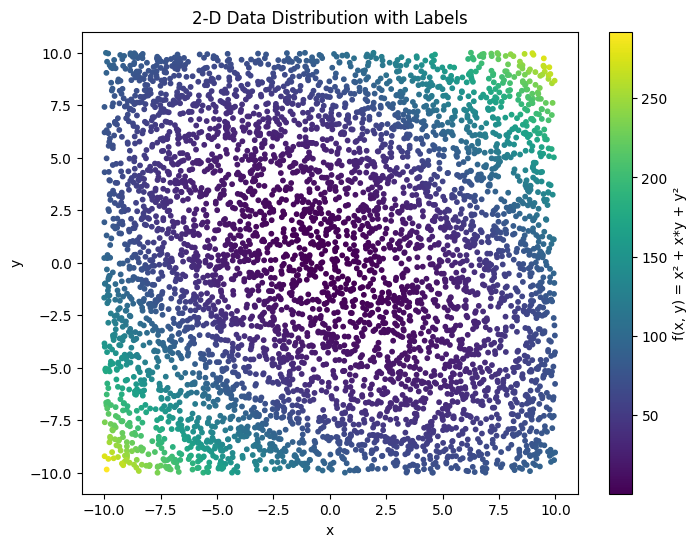

In [4]:
dataset_obj.plot_data()

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.layers(x)



In [6]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [7]:
num_epochs = 100
train_losses = []
test_losses=[]
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = total_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item() * inputs.size(0)
    avg_test_loss = total_test_loss / len(test_dataset)
    test_losses.append(avg_test_loss)
    
    # Update learning rate based on test loss
    scheduler.step(avg_test_loss)

    if epoch%5 == 0:
        print(f"Epoch {epoch+1:03d}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")



Epoch 001: Train Loss = 3387.7009, Test Loss = 898.9113
Epoch 006: Train Loss = 237.8123, Test Loss = 225.0272
Epoch 011: Train Loss = 87.3009, Test Loss = 81.3194
Epoch 016: Train Loss = 33.0993, Test Loss = 29.8042
Epoch 021: Train Loss = 11.9994, Test Loss = 11.0911
Epoch 026: Train Loss = 5.6930, Test Loss = 5.4108
Epoch 031: Train Loss = 2.8490, Test Loss = 2.9445
Epoch 036: Train Loss = 1.5494, Test Loss = 1.5418
Epoch 041: Train Loss = 0.9384, Test Loss = 0.8218
Epoch 046: Train Loss = 0.7033, Test Loss = 0.5754
Epoch 051: Train Loss = 0.5118, Test Loss = 0.4486
Epoch 056: Train Loss = 0.5423, Test Loss = 0.3443
Epoch 061: Train Loss = 0.4316, Test Loss = 0.3834
Epoch 066: Train Loss = 0.3318, Test Loss = 0.4199
Epoch 071: Train Loss = 0.2086, Test Loss = 0.4004
Epoch 076: Train Loss = 0.1993, Test Loss = 0.2109
Epoch 081: Train Loss = 0.2023, Test Loss = 0.5449
Epoch 086: Train Loss = 0.1577, Test Loss = 0.1977
Epoch 091: Train Loss = 0.1619, Test Loss = 0.1791
Epoch 096: Train

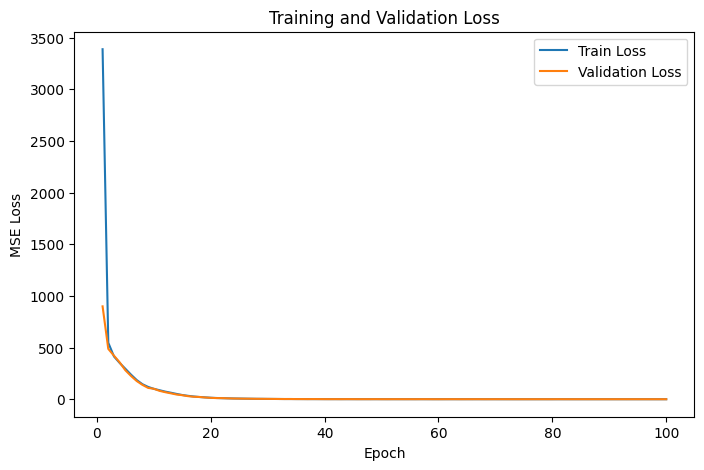

In [8]:
# Plot losses if needed
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

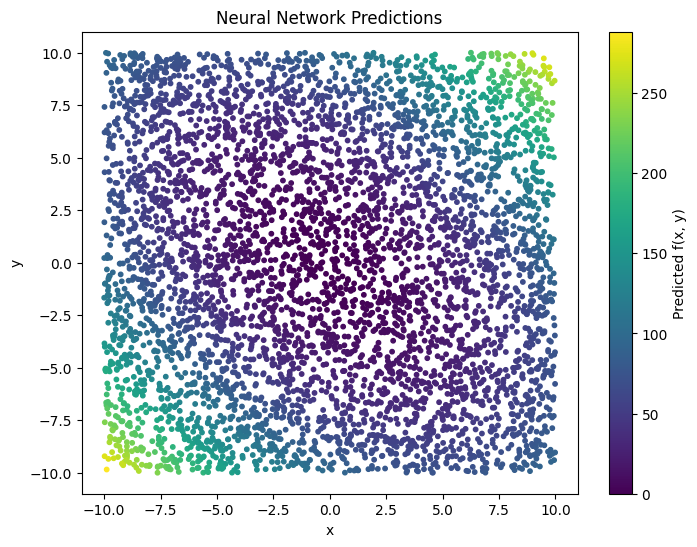

In [9]:
dataset_obj.plot_predictions(model)